## Tutorial soures
https://www.kaggle.com/ternaryrealm/lstm-time-series-explorations-with-keras
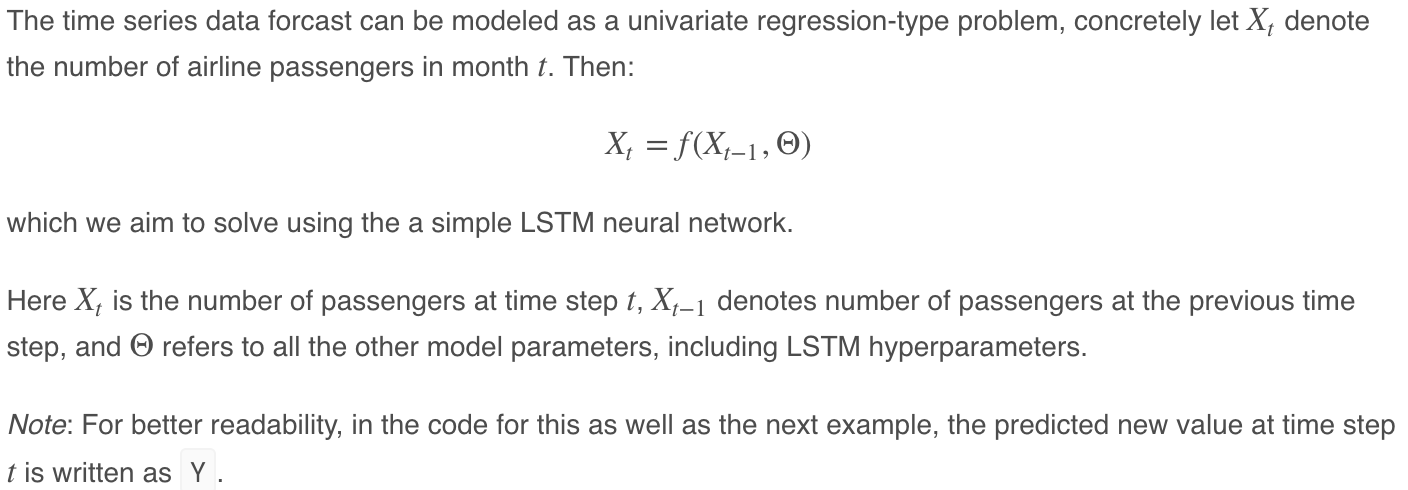
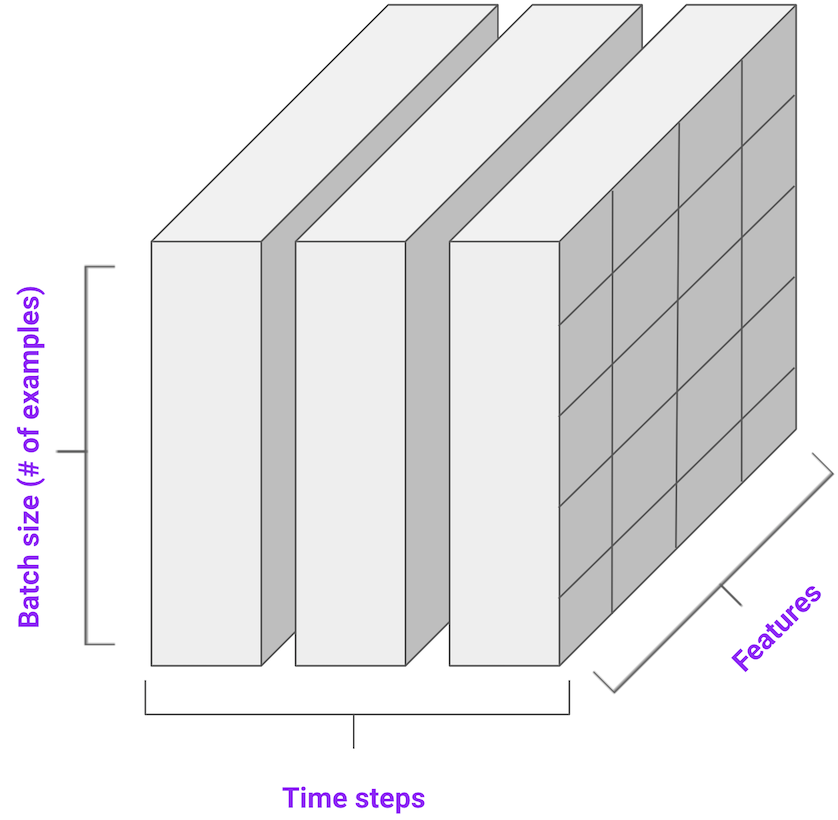

## Libs

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib as matpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import math

# Using the Tensorflow backend (default).
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle

matpl.rcParams['figure.figsize'] = (10, 8)
matpl.rcParams['axes.grid'] = False

Using TensorFlow backend.


## Data

In [2]:
%store -r data_GLD
data_GLD.head(2)

,Adj Close
Date,
2009-06-01,93.709999
2009-06-08,92.169998


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a453e20f0>],
      dtype=object)

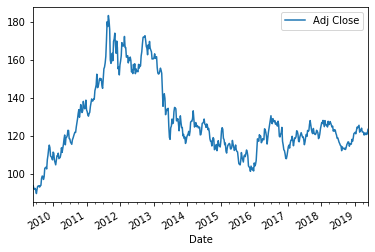

In [3]:
data_GLD.plot(subplots=True)

In [4]:
mm = MinMaxScaler(feature_range = (0,1))

In [5]:
dataset = mm.fit_transform(data_GLD)

In [6]:
#visualize a dataset[0:2]few data
dataset[0:2]

array([[0.04409563],
       [0.02765317]])

1 data every week. 52 data per year, 522 data in total.
* use the past 2 months (8 weeks) to predict 1 week ahead.
* create window of last 8 obs to train model
Parameters:
* history_size - size of past window
* target_size - how far in future model should learn to predict

6 years of training data = 313 weeks. 
Rest of the 209 weeks are for validation.

In [7]:
split_size = 0.6

train_size = int(len(dataset) * split_size)
#validation
test_size = len(dataset) - train_size

train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

print("Number of entries (training set, test set): " + str((len(train), len(test))))

Number of entries (training set, test set): (313, 209)


In [8]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[i + window_size, 0])
    return(np.array(data_X), np.array(data_Y))


In [9]:
# Create test and training sets for one-step-ahead regression.
window_size = 1
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

# Reshape the input data into appropriate form for Keras.
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))
print("New training data shape:")
print(train_X.shape)

Original training data shape:
(311, 1)
New training data shape:
(311, 1, 1)


## Univar Forecasting Model
* Part 1 - model will be given the last 4 obs and needs to learn to predict price in the next time step.

In [10]:
def fit_model(train_X, train_Y, window_size = 1):
    model = Sequential()
    
    model.add(LSTM(4, 
                   input_shape = (1, window_size)))
    model.add(Dense(1))
    model.compile(loss = "mean_squared_error", 
                  optimizer = "adam")
    model.fit(train_X, 
              train_Y, 
              epochs = 10, 
              batch_size = 1, 
              verbose = 2)
    
    return(model)

# Fit the first model.
model1 = fit_model(train_X, train_Y, window_size)

W0904 00:46:59.041172 4735882688 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 00:46:59.073782 4735882688 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 00:46:59.076493 4735882688 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 00:46:59.325012 4735882688 deprecation_wrapper.py:119] From //anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0904 00:46:59.501955 4735882688 deprecation.py:323] From //anaconda3/li

Epoch 1/10
 - 2s - loss: 0.0802
Epoch 2/10
 - 1s - loss: 0.0221
Epoch 3/10
 - 1s - loss: 0.0143
Epoch 4/10
 - 1s - loss: 0.0074
Epoch 5/10
 - 1s - loss: 0.0033
Epoch 6/10
 - 1s - loss: 0.0017
Epoch 7/10
 - 1s - loss: 0.0012
Epoch 8/10
 - 1s - loss: 0.0012
Epoch 9/10
 - 1s - loss: 0.0012
Epoch 10/10
 - 1s - loss: 0.0012


## Results 
### Predictions and model evaluations
The advantage of using the RMSE is that it's in the same unit as the original data, i.e. price/wk (1.000 passengers / month in Kaggle example).

In [11]:
def predict_and_score(model, X, Y):
    # Make predictions on the original scale of the data.
    pred = mm.inverse_transform(model.predict(X))
    # Prepare Y data to also be on the original scale for interpretability.
    orig_data = mm.inverse_transform([Y])
    # Calculate RMSE.
    score = math.sqrt(mean_squared_error(orig_data[0], pred[:, 0]))
    return(score, pred)

rmse_train, train_predict = predict_and_score(model1, train_X, train_Y)
rmse_test, test_predict = predict_and_score(model1, test_X, test_Y)

print("Training data score: %.2f RMSE" % rmse_train)
print("Test data score: %.2f RMSE" % rmse_test)

Training data score: 3.24 RMSE
Test data score: 2.11 RMSE


### Plotting and comparing original data, predictions, forecasts

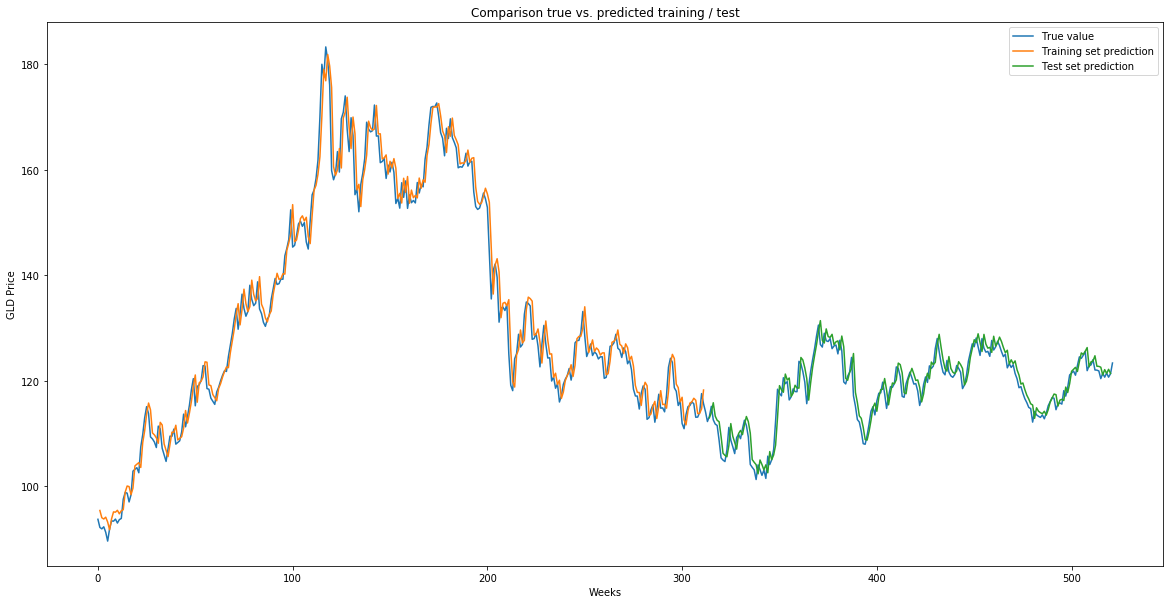

In [12]:
# Start with training predictions.
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[window_size:len(train_predict) + window_size, :] = train_predict

# Add test predictions.
test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (window_size * 2) + 1:len(dataset) - 1, :] = test_predict

# Create the plot.
plt.figure(figsize = (20, 10))
plt.plot(mm.inverse_transform(dataset), label = "True value")
plt.plot(train_predict_plot, label = "Training set prediction")
plt.plot(test_predict_plot, label = "Test set prediction")
plt.xlabel("Weeks")
plt.ylabel("GLD Price")
plt.title("Comparison true vs. predicted training / test")
plt.legend()
plt.show()